In [12]:
import zipfile
import os

# Path to the ZIP file (replace with your uploaded file name)
zip_file_path = "modifyTest.zip"  # Example: oil-spill-detection.zip

# Extraction path
extract_folder = "modifyTest"  # Folder where the dataset will be extracted

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"✅ Dataset extracted to: {extract_folder}")


✅ Dataset extracted to: modifyTest


In [13]:
# List files in the extracted folder
for root, dirs, files in os.walk(extract_folder):
    print(f"Folder: {root}")
    print(f"Subfolders: {dirs}")
    print(f"Files: {files}")
    print('-' * 50)


Folder: modifyTest
Subfolders: ['modifyTest']
Files: []
--------------------------------------------------
Folder: modifyTest/modifyTest
Subfolders: ['masks', 'images']
Files: []
--------------------------------------------------
Folder: modifyTest/modifyTest/masks
Subfolders: []
Files: ['Oil (1)_tile_16.jpg', 'Oil (1)_tile_64.jpg', 'Oil (1)_tile_01.jpg', 'Oil (1)_tile_50.jpg', 'Oil (1)_tile_46.jpg', 'Oil (1)_tile_26.jpg', 'Oil (1)_tile_22.jpg', 'Oil (1)_tile_02.jpg', 'Oil (1)_tile_52.jpg', 'Oil (1)_tile_67.jpg', 'Oil (1)_tile_42.jpg', 'Oil (1)_tile_00.jpg', 'Oil (1)_tile_23.jpg', 'Oil (1)_tile_65.jpg', 'Oil (1)_tile_73.jpg', 'Oil (1)_tile_33.jpg', 'Oil (1)_tile_63.jpg', 'Oil (1)_tile_60.jpg', 'Oil (1)_tile_31.jpg', 'Oil (1)_tile_41.jpg', 'Oil (1)_tile_14.jpg', 'Oil (1)_tile_74.jpg', 'Oil (1)_tile_66.jpg', 'Oil (1)_tile_44.jpg', 'Oil (1)_tile_04.jpg', 'Oil (1)_tile_24.jpg', 'Oil (1)_tile_53.jpg', 'Oil (1)_tile_40.jpg', 'Oil (1)_tile_20.jpg', 'Oil (1)_tile_61.jpg', 'Oil (1)_tile_35.jpg'

In [14]:
import os
import cv2
import numpy as np

# Map color to label
color_to_label = {
    (0, 0, 0): 0,         # Background
    (255, 0, 124): 1,      # Oil
    (255, 204, 51): 2,     # Others
    (51, 221, 255): 3      # Water
}


In [15]:
import os
import cv2
import numpy as np

IMG_SIZE = (128, 128)

# Function to load images and masks
def load_images_and_masks(image_folder, mask_folder):
    images = []
    masks = []

    for img_name in os.listdir(image_folder):
        img_path = os.path.join(image_folder, img_name)
        mask_path = os.path.join(mask_folder, img_name)  # Mask has the same name

        # Load image
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load mask
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, IMG_SIZE)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Convert mask colors to class labels
        label_map = np.zeros((IMG_SIZE[0], IMG_SIZE[1]), dtype=np.uint8)

        for color, label in color_to_label.items():
            mask_mask = np.all(mask == color, axis=-1)
            label_map[mask_mask] = label

        # Append the image and mask
        images.append(img / 255.0)  # Normalize images
        masks.append(label_map)

    return np.array(images), np.array(masks)


In [22]:
# Replace with your dataset paths
image_folder = r"/content/modifyTest/modifyTest/images"
mask_folder = r"/content/modifyTest/modifyTest/masks"

# Load the images and masks
X, y = load_images_and_masks(image_folder, mask_folder)

# Print the shape
print(f"Images shape: {X.shape}")
print(f"Masks shape: {y.shape}")


Images shape: (64, 128, 128, 3)
Masks shape: (64, 128, 128)


In [23]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the masks
y_encoded = to_categorical(y, num_classes=4)

# Print the shape
print("Masks shape after one-hot encoding:", y_encoded.shape)


Masks shape after one-hot encoding: (64, 128, 128, 4)


In [24]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (51, 128, 128, 3) (51, 128, 128, 4)
Testing set shape: (13, 128, 128, 3) (13, 128, 128, 4)


In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout

def build_segmentation_model(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c2 = Dropout(0.1)(c2)
    c2 = MaxPooling2D((2, 2))(c2)

    # Decoder
    u1 = UpSampling2D((2, 2))(c2)
    u1 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)

    u2 = UpSampling2D((2, 2))(u1)
    u2 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(u2)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the model with 128x128 input size
model = build_segmentation_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 4)         │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,916 (292.64 KB)

 Trainable params: 74,916 (292.64 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5694 - loss: 1.3267 - val_accuracy: 0.8905 - val_loss: 1.1088
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.5753 - loss: 1.1164 - val_accuracy: 0.8904 - val_loss: 0.9244
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.5887 - loss: 1.0041 - val_accuracy: 0.0302 - val_loss: 1.0418
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.3334 - loss: 0.9960 - val_accuracy: 0.0172 - val_loss: 1.1740
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.3262 - loss: 0.9824 - val_accuracy: 0.0240 - val_loss: 1.0296
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.4483 - loss: 0.9669 - val_accuracy: 0.8839 - val_loss: 0.9585
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.5922 - loss: 0.9561 - val_accuracy: 0.8891 - val_loss: 0.9771
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.8453 - loss: 0.9109 - val_accuracy: 0.1208 - val_loss: 1.0164
Epoch 9/20
2

In [27]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9007 - loss: 0.4366
Test Loss: 0.4366
Test Accuracy: 0.9007


In [28]:
# Save the model
model.save("oil_spill_segmentation_model_128x128.h5")
print("Model saved successfully!")


Model saved successfully!


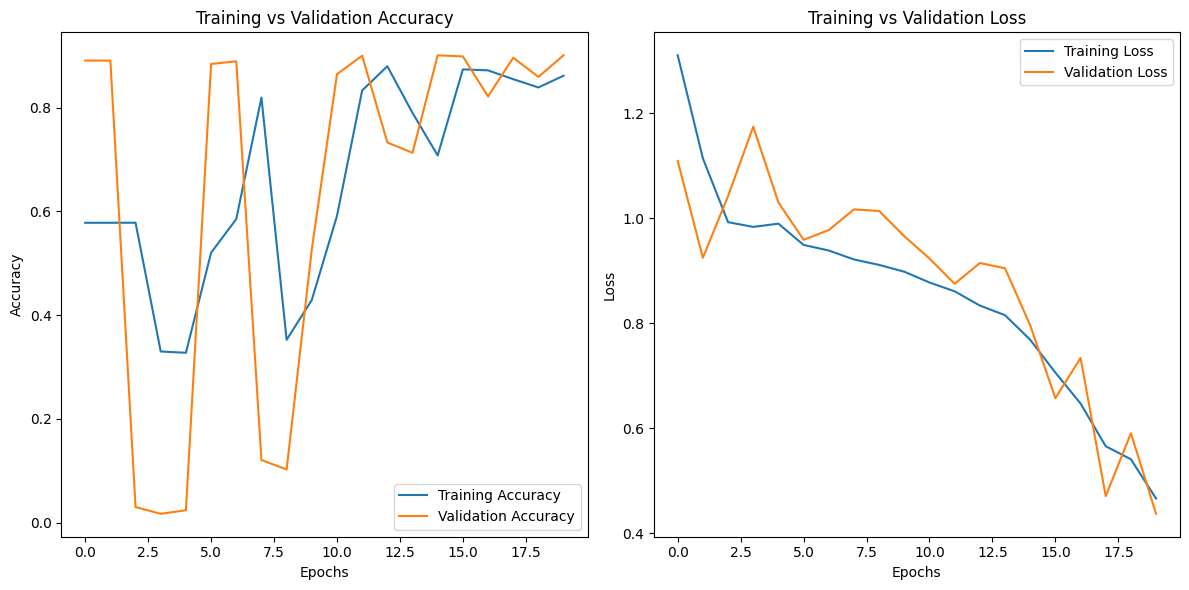

In [29]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [30]:
import zipfile
import os

# Path to the ZIP file (replace with your uploaded file name)
zip_file_path = "modifyTest-test.zip"  # Example: oil-spill-detection.zip

# Extraction path
extract_folder = "modifyTest-test"  # Folder where the dataset will be extracted

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"✅ Dataset extracted to: {extract_folder}")

✅ Dataset extracted to: modifyTest-test


In [31]:
from tensorflow.keras.models import load_model

# Load the model
model_path = "/content/oil_spill_segmentation_model_128x128.h5"  # Path to your model
model = load_model(model_path)
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [32]:
import os
import cv2
import numpy as np

IMG_SIZE = (128, 128)

# Function to load and preprocess test images
def load_test_images(folder):
    test_images = []
    image_names = []

    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)

        # Load and resize the image
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Normalize the image
        img = img / 255.0

        test_images.append(img)
        image_names.append(img_name)

    return np.array(test_images), image_names


In [33]:
# Path to your new test folder
test_folder = "/content/modifyTest-test/modifyTest/images"  # Replace with the actual path

# Load and preprocess the images
X_test_new, image_names = load_test_images(test_folder)

print(f"✅ Loaded {len(X_test_new)} test images with shape: {X_test_new.shape}")


✅ Loaded 64 test images with shape: (64, 128, 128, 3)


In [34]:
# Make predictions
y_pred = model.predict(X_test_new)

# Print the shape of predictions
print(f"✅ Predictions shape: {y_pred.shape}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
✅ Predictions shape: (64, 128, 128, 4)


In [35]:
def convert_prediction_to_labels(prediction):
    """Converts probability output to class labels."""
    return np.argmax(prediction, axis=-1)


In [36]:
def overlay_prediction(image, mask, alpha=0.5):
    """Overlay the predicted mask on the original image."""

    # Map class labels to colors
    colors = {
        0: (0, 0, 0),         # Background → Black
        1: (255, 0, 124),      # Oil → Pink
        2: (255, 204, 51),     # Others → Yellow
        3: (51, 221, 255)      # Water → Blue
    }

    overlay = np.zeros_like(image)

    # Apply colors to the mask
    for label, color in colors.items():
        overlay[mask == label] = np.array(color) / 255.0

    # Blend the mask with the original image
    blended = cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)

    return blended


In [37]:
import matplotlib.pyplot as plt

def display_test_predictions(X, y_pred, image_names, num=5):
    """Display original images, predicted masks, and overlays."""

    plt.figure(figsize=(15, 10))

    for i in range(min(num, len(X))):
        # Original image
        plt.subplot(3, num, i + 1)
        plt.imshow(X[i])
        plt.title(f"Original: {image_names[i]}")
        plt.axis('off')

        # Predicted mask
        predicted_mask = convert_prediction_to_labels(y_pred[i])
        plt.subplot(3, num, i + 1 + num)
        plt.imshow(predicted_mask, cmap='jet')
        plt.title("Predicted Mask")
        plt.axis('off')

        # Overlayed mask on original image
        overlayed_image = overlay_prediction(X[i], predicted_mask)
        plt.subplot(3, num, i + 1 + 2 * num)
        plt.imshow(overlayed_image)
        plt.title("Overlayed Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


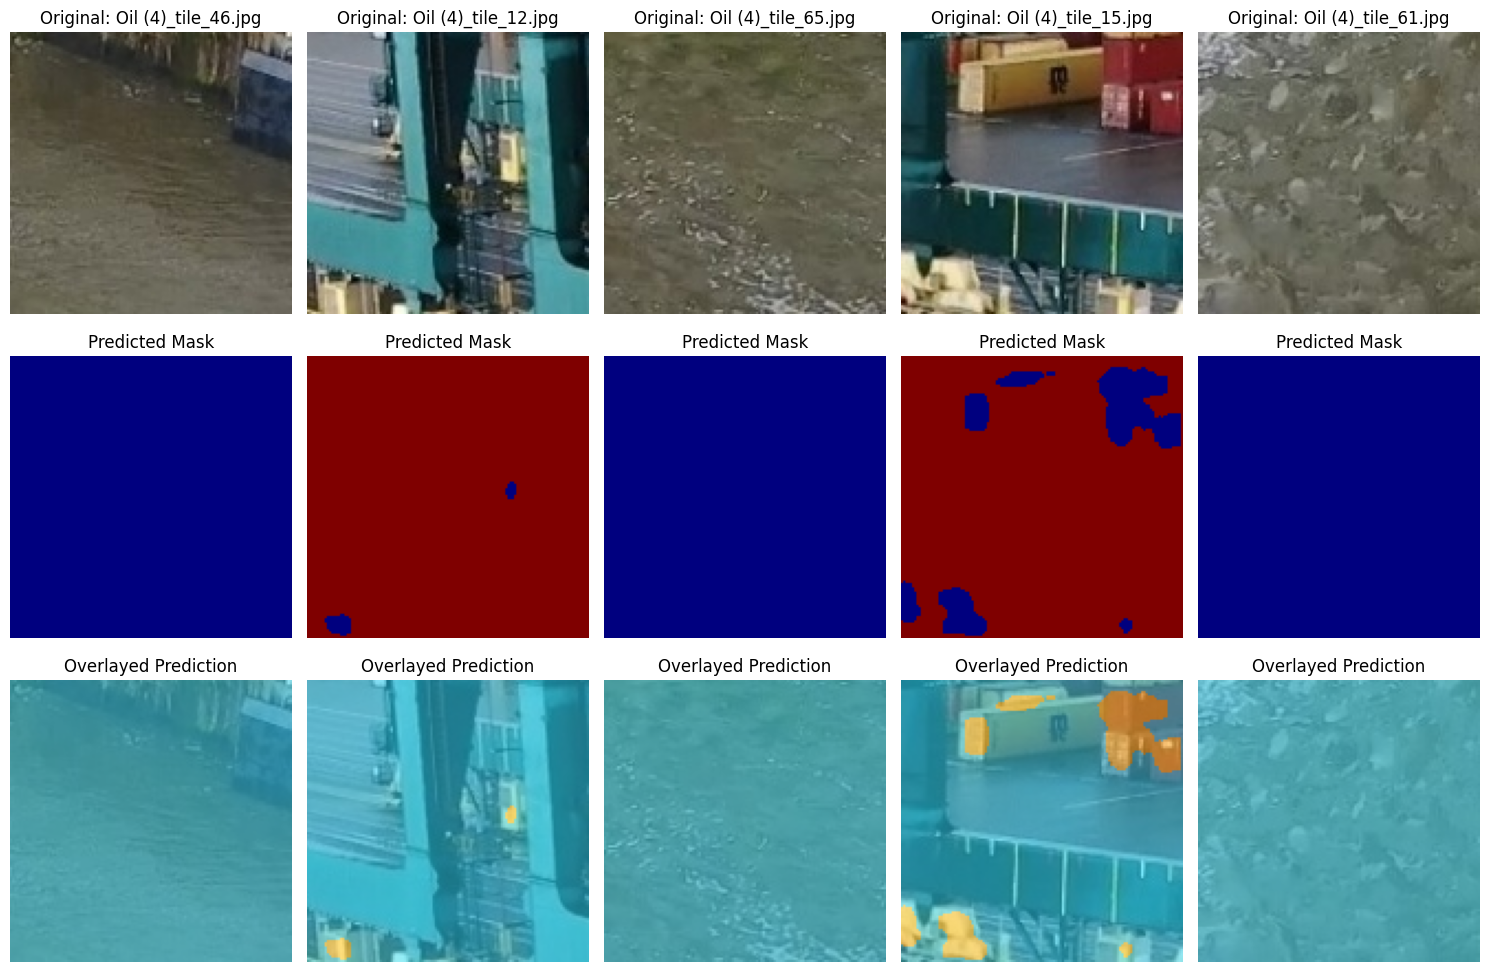

In [38]:
# Display predictions
display_test_predictions(X_test_new, y_pred, image_names, num=5)


In [39]:
def save_predicted_masks(X, y_pred, output_folder):
    """Save the predicted masks as image files."""
    os.makedirs(output_folder, exist_ok=True)

    for i in range(len(X)):
        # Convert probabilities to class labels
        predicted_mask = convert_prediction_to_labels(y_pred[i])

        # Save mask as an image
        mask_path = os.path.join(output_folder, f"mask_{i + 1}.png")
        plt.imsave(mask_path, predicted_mask, cmap='jet')

    print(f"✅ Masks saved in: {output_folder}")


In [40]:
# Path to save the masks
output_folder = "/content/predicted_masks"

# Save the masks
save_predicted_masks(X_test_new, y_pred, output_folder)


✅ Masks saved in: /content/predicted_masks
